# main code

In [1]:
import os
import tensorflow as tf
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.applications.efficientnet import preprocess_input
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt

# data paths

In [2]:
train_dir = "original_data_set/train"
test_dir  = "original_data_set/test"

img_size = (224, 224)
batch_size = 32

## load dataset

In [3]:
train_ds = image_dataset_from_directory(
    train_dir,
    image_size=img_size,
    batch_size=batch_size,
    shuffle=True
)

test_ds = image_dataset_from_directory(
    test_dir,
    image_size=img_size,
    batch_size=batch_size,
    shuffle=False
)

class_names = train_ds.class_names
print("Classes:", class_names)



Found 11231 files belonging to 6 classes.
Found 2698 files belonging to 6 classes.
Classes: ['freshapples', 'freshbananas', 'freshoranges', 'rottenapples', 'rottenbananas', 'rottenoranges']


# prefetch

In [6]:
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.prefetch(AUTOTUNE)
test_ds = test_ds.prefetch(AUTOTUNE)

# build model

In [9]:
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Lambda
from tensorflow.keras.models import Sequential
from tensorflow.keras.applications.efficientnet import preprocess_input

# Load base model
base_model = EfficientNetB0(
    include_top=False,
    weights="imagenet",
    input_shape=(224, 224, 3)
)
base_model.trainable = False   # Freeze backbone

# Build model
model = Sequential([
    Lambda(preprocess_input, input_shape=(224, 224, 3)),  # <-- define input here!
    base_model,
    GlobalAveragePooling2D(),
    Dropout(0.3),
    Dense(6, activation="softmax")
])

model.compile(
    optimizer="adam",
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

model.summary()


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lambda_1 (Lambda)           (None, 224, 224, 3)       0         
                                                                 
 efficientnetb0 (Functional  (None, 7, 7, 1280)        4049571   
 )                                                               
                                                                 
 global_average_pooling2d_2  (None, 1280)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dropout_2 (Dropout)         (None, 1280)              0         
                                                                 
 dense_2 (Dense)             (None, 6)                 7686      
                                                                 
Total params: 4057257 (15.48 MB)
Trainable params: 768

### train model

In [13]:
history = model.fit(train_ds, epochs=3, validation_data=test_ds)

Epoch 1/3
351/351 [==============================] - 294s 832ms/step - loss: 0.0319 - accuracy: 0.9925 - val_loss: 0.0221 - val_accuracy: 0.9952
Epoch 2/3
351/351 [==============================] - 318s 905ms/step - loss: 0.0290 - accuracy: 0.9924 - val_loss: 0.0185 - val_accuracy: 0.9956
Epoch 3/3
351/351 [==============================] - 270s 768ms/step - loss: 0.0245 - accuracy: 0.9936 - val_loss: 0.0147 - val_accuracy: 0.9967


# save model

In [14]:
os.makedirs("models", exist_ok=True)
model.save("models/efficientnet_fruit.h5")
print("MODEL SAVED!")


MODEL SAVED!


# plot accuracy and loss

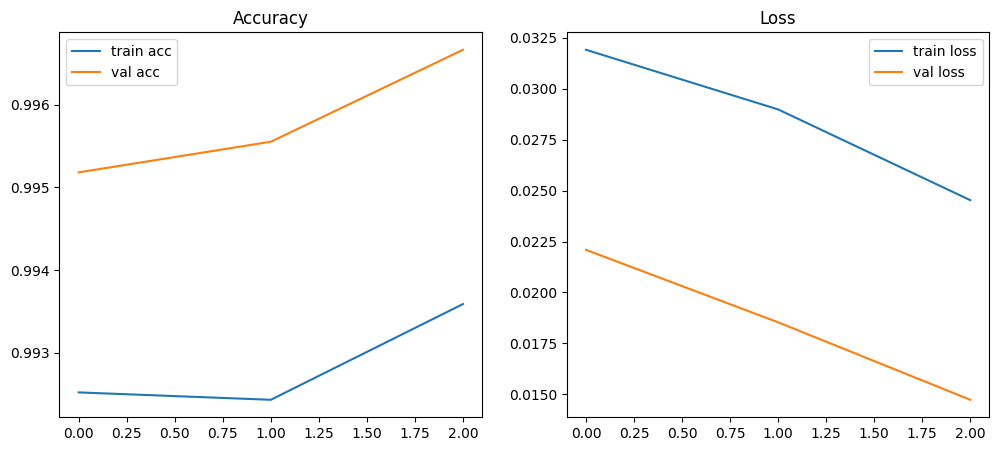

In [15]:
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(history.history["accuracy"], label="train acc")
plt.plot(history.history["val_accuracy"], label="val acc")
plt.legend()
plt.title("Accuracy")

plt.subplot(1,2,2)
plt.plot(history.history["loss"], label="train loss")
plt.plot(history.history["val_loss"], label="val loss")
plt.legend()
plt.title("Loss")
plt.show()


# get predictions for test set 

In [16]:
y_true = []
y_pred = []

for images, labels in test_ds:
    preds = model.predict(images)
    y_true.extend(labels.numpy())
    y_pred.extend(np.argmax(preds, axis=1))

y_true = np.array(y_true)
y_pred = np.array(y_pred)

1/1 [==============================] - 2s 2s/step


# CLASSIFICATION REPORT

In [17]:
print("\n=== 6-Class Model (Fruit + Freshness) ===")
print(classification_report(y_true, y_pred, target_names=class_names))

print("\nConfusion Matrix:")
print(confusion_matrix(y_true, y_pred))


=== 6-Class Model (Fruit + Freshness) ===
               precision    recall  f1-score   support

  freshapples       0.99      1.00      0.99       395
 freshbananas       1.00      1.00      1.00       381
 freshoranges       1.00      1.00      1.00       388
 rottenapples       1.00      0.99      0.99       601
rottenbananas       1.00      1.00      1.00       530
rottenoranges       1.00      1.00      1.00       403

     accuracy                           1.00      2698
    macro avg       1.00      1.00      1.00      2698
 weighted avg       1.00      1.00      1.00      2698


Confusion Matrix:
[[395   0   0   0   0   0]
 [  0 381   0   0   0   0]
 [  0   0 387   0   0   1]
 [  5   0   0 595   0   1]
 [  0   0   0   0 530   0]
 [  0   0   1   1   0 401]]


#  test accurecy

In [23]:
loss, acc = model.evaluate(test_ds, verbose=0)
print(f"Final Test Accuracy: {acc*100:.2f}%")


Final Test Accuracy: 99.67%
